# Vehicle Detection Pipeline
---
This vehicle detection project proceeds in the following sequence:

1. Extract Features from images
2. Set Classifier
    * See [`Training_Classifier.ipynb`](./Training_Classifier.ipynb) if you want to see how to train classifier in detail.
3. Search and Classify
4. Remove Multiple Detections & False Positives

Using this pipeline, you can see the process of detecting a vehicle in the given video [`project_video.mp4`](./project_video.mp4) and producing the result in  [`output_video.mp4`](./output_video.mp4). See [**`Generate_Video.ipynb`**](./Generate_Video.ipynb)!

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from utils.lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

### 0. Prepare Data
---
In this pipeline ipython notebook, I'll use small dataset.

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [3]:
images = glob.glob('./test_images/vehicles/*/*.jpeg', recursive=True)
cars = []
notcars = []

for image in images:
    image_names = image.split('/')
    fname = image_names[-1]
    if 'image' in fname or 'extra' in fname:
        notcars.append(image)
    else:
        cars.append(image)
        
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


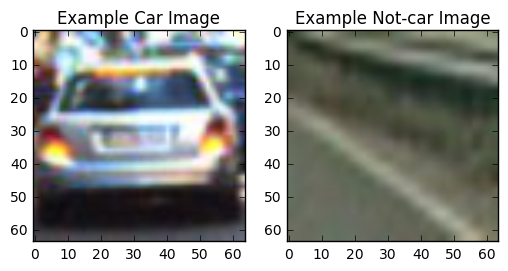

In [4]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### 1. Extract Features from Images
---
These features are considered:
* **Spatially Binned Color** 
    * `color_space` = `YCrCB`, `spatial_size` = (32,32)
* **Color Histogram** 
    * `bin` = 32
* **HOG for all image channel**
    * `orient` = 9, `pix_per_cell` = 8, `cell_per_block` = 2
    
and using `sklearn.preprocessing.StandardScaler()`, feature data is **normalized**.

In [5]:
# hyperparameters for feature extraction
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32

color_space = 'YCrCb'
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

In [6]:
# extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

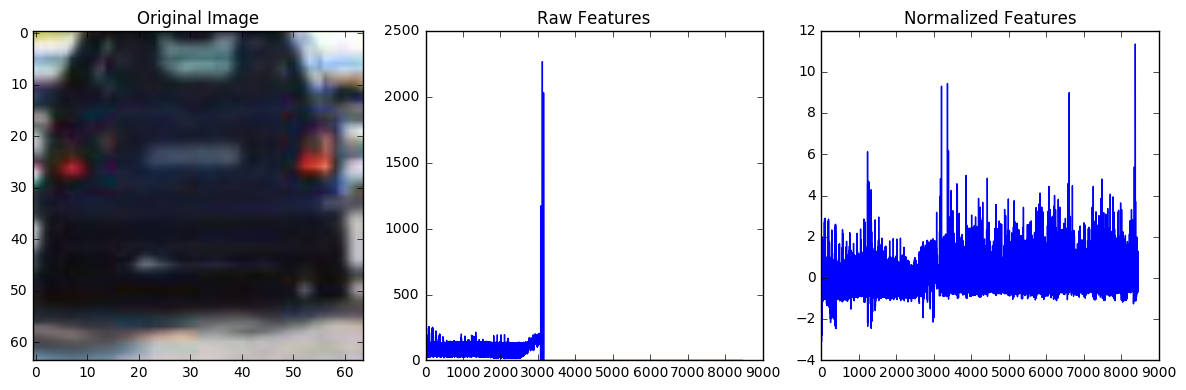

In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### 2. Set Classifier
---
In this section, Trained linearSVM classifier will be loaded. If you want to see the detail of training procedure, please see [`Training_Classifier.ipynb`](./Training_Classifier.ipynb).

I trained linearSVM using `8792` cars and `8968` non-cars data. The test accuracy of this classifier is almost **0.98** and it takes **4ms** to predict 10 labels.

In [8]:
# load trained classifier
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]

In [9]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9885
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00218 Seconds to predict 10 labels with SVC


### 3. Search and Classify
---
In this section, **Hog sub-sampling widow search** is implemented. it allows us to only have to extract the Hog features once. and then using classifier trained in previous section, each window is classified as either a car or a non-car.

To run searching algorithm fast, ROI and is set in image coordinate.
* `ystart` = 400
* `ystop` = 656

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # box list
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                startx = xbox_left
                endx = xbox_left+win_draw
                starty = ytop_draw+ystart
                endy = ytop_draw+win_draw+ystart
                cv2.rectangle(draw_img,(startx, starty),(endx,endy),(0,0,255),6)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box_list.append(((startx, starty), (endx, endy)))
                
    return draw_img, box_list

In [11]:
ystart = 400
ystop = 656
scale = 1.5

In [12]:
img = mpimg.imread('./test_images/test5.jpg')
out_img,_ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

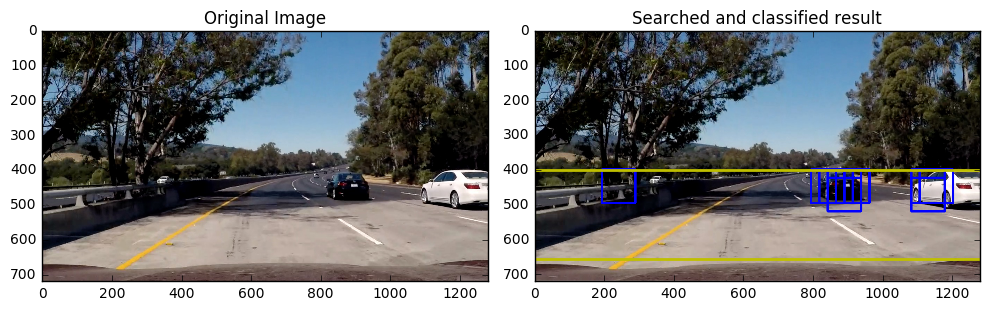

In [13]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(out_img)
plt.plot([0, out_img.shape[1]], [ystart, ystart], color='y', linewidth=2)
plt.plot([0, out_img.shape[1]], [ystop, ystop], color='y', linewidth=2)
plt.xlim([0, out_img.shape[1]])
plt.ylim([out_img.shape[0], 0])
plt.title('Searched and classified result')
fig.tight_layout()
plt.show()

### 4. Remove Multiple Detections & False Positives
---
In section 3, You can see that overlapping detections exist for each of the two vehicles on right side. You also find a false positive detction on the guardrail on the left side.

In this section, A **heat-map** will be built from these detections in order to **combine overlapping detections** and **remove false positives**. This makes final output image.

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

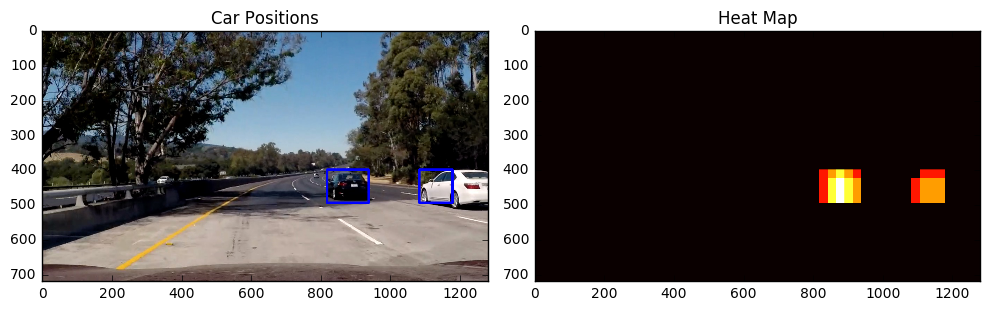

In [15]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
_, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()